In [1]:
# Import modules
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import make_pipeline

today = dt.date.today()
this_month = pd.to_datetime(str(today.year)+'-'+str(today.month)+'-01')
%qtconsole

In [2]:
# Define local directories
master_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\'
data_raw_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\raw\\'
data_interim_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\interim\\'
data_processed_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\processed\\'
data_external_dir = 'C:\\Users\\Bryan\\OneDrive\\02 GitHub\\rig-count_L48\\data\\external\\'

In [3]:
df = pd.read_csv(data_processed_dir+'processed_data.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)
df.head(2)

,date,Total US RigCount,wti_spot,wti_spot_lag_14,brent_spot,usa_net_import,usa_stocks_all,usa_l48_prod,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons,non-oecd_cons,world_cons
0,2011-02-04,818.0,89.520,82.030,100.358,8.876,1049.948,4.991,34.562296,33.144409,3.700132,54.123720,47.658621,42.542887,90.201507
1,2011-02-11,805.0,85.514,84.928,99.904,8.233,1050.807,4.995,34.228542,32.844592,3.700252,54.236533,47.483407,42.376184,89.859591


In [4]:
# Remove wti_spot, brent_spot for redundant values

df = df.drop(['wti_spot','brent_spot'],axis=1)
df.head(2)

,date,Total US RigCount,wti_spot_lag_14,usa_net_import,usa_stocks_all,usa_l48_prod,opec_tot_prod,opec_crud_capac,opec_surp_capac,non-opec_tot_prod,oecd_cons,non-oecd_cons,world_cons
0,2011-02-04,818.0,82.030,8.876,1049.948,4.991,34.562296,33.144409,3.700132,54.123720,47.658621,42.542887,90.201507
1,2011-02-11,805.0,84.928,8.233,1050.807,4.995,34.228542,32.844592,3.700252,54.236533,47.483407,42.376184,89.859591


## Train Test Split
Define features X, and target variable y

In [5]:
X = df.iloc[:,2:]
y = df.iloc[:,1]

date = df.date

#scaler = MinMaxScaler()

#scaler.fit(X)
#X = scaler.transform(X)

#X = pd.DataFrame(X,columns=df.iloc[:,2:].columns)

#X[['world_cons','wti_spot_lag_14']].plot(figsize=(12,10))

#fig, ax = plt.subplots(figsize=(12,10))
#ax.plot(date,X)


In [6]:
# Define functions
def plot_model(date,X,y,ts_cv,pipe):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.plot(date,y)
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(bymonth = range(0,13,6)))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=75)

    mse = []
    r2 = []

    for ii, (tr, tt) in enumerate(ts_cv.split(X,y)):
        X_tr = X.iloc[tr,:]
        y_tr = y.iloc[tr]
        X_tt = X.iloc[tt,:]
        y_tt = y.iloc[tt]
        pipe.fit(X_tr,y_tr)

        y_pred = pipe.predict(X_tt)

        mse.append(mean_squared_error(y_pred,y_tt,squared=False))
        r2.append(r2_score(y_pred,y_tt))

        ax.plot(date[tt],y_pred, label='test iter no '+str(ii+1))

    plt.legend()
    plt.show()

    return 'rmse = '+str(np.mean(mse))+'. r2 = '+str(np.mean(r2))

### Linear Regression 
Baseline model will be a linear regression with all features.

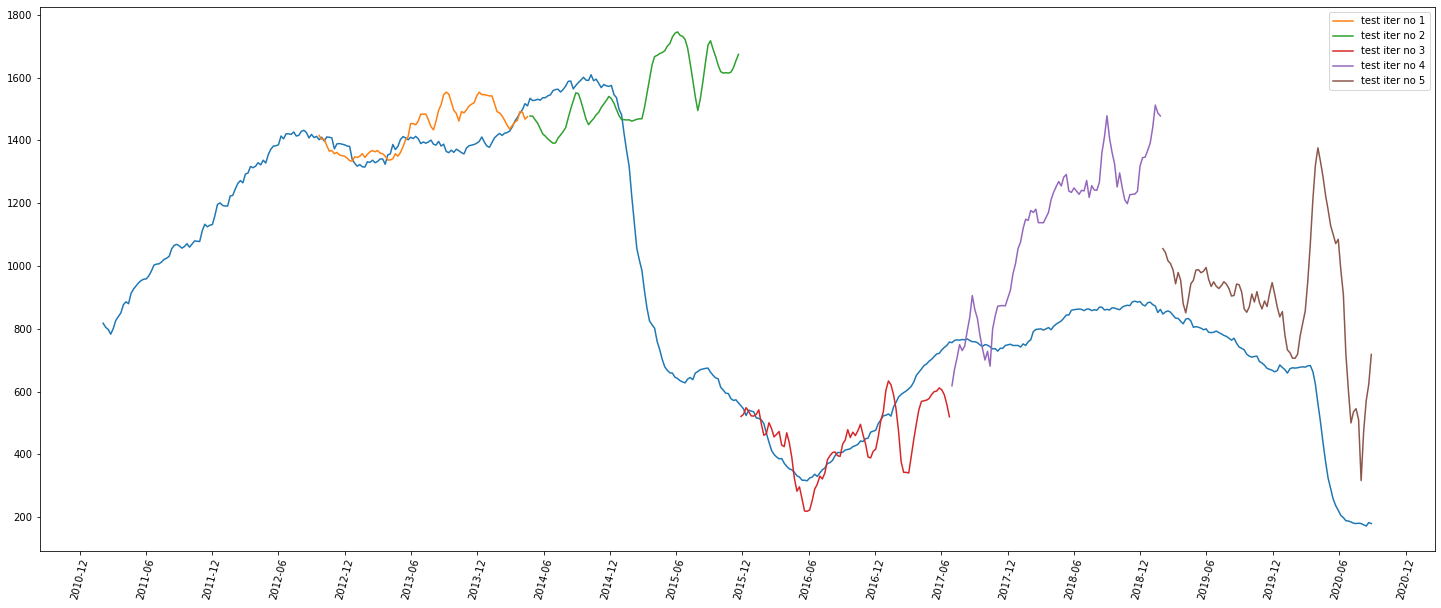

'rmse = 318.3239953419649. r2 = -9.165301595964518'

In [7]:
# Baseline linear regression with no additional features
model = LinearRegression()
cv = TimeSeriesSplit(n_splits=5)
pipe = make_pipeline(model)

plot_model(date,X,y,cv,pipe)

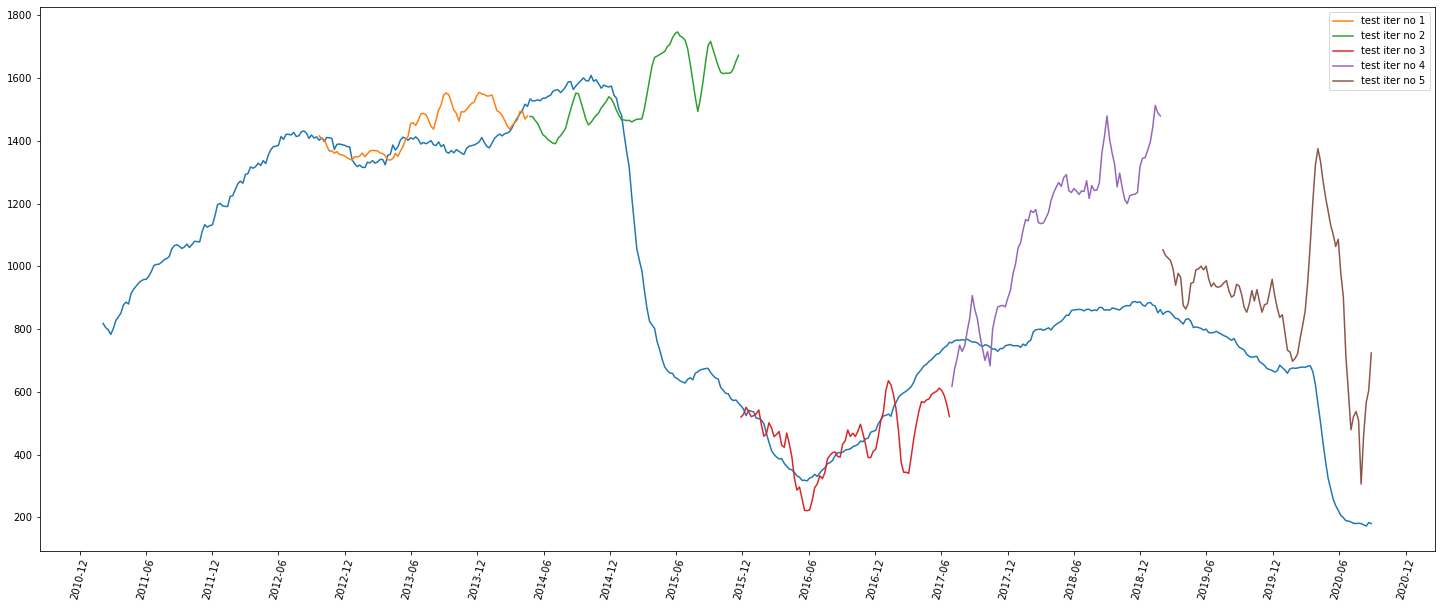

'rmse = 318.41958408100186. r2 = -9.175108444882374'

In [8]:
# Add scaler to features
scaler = MinMaxScaler()
pipe = make_pipeline(scaler,model)

plot_model(date,X,y,cv,pipe)

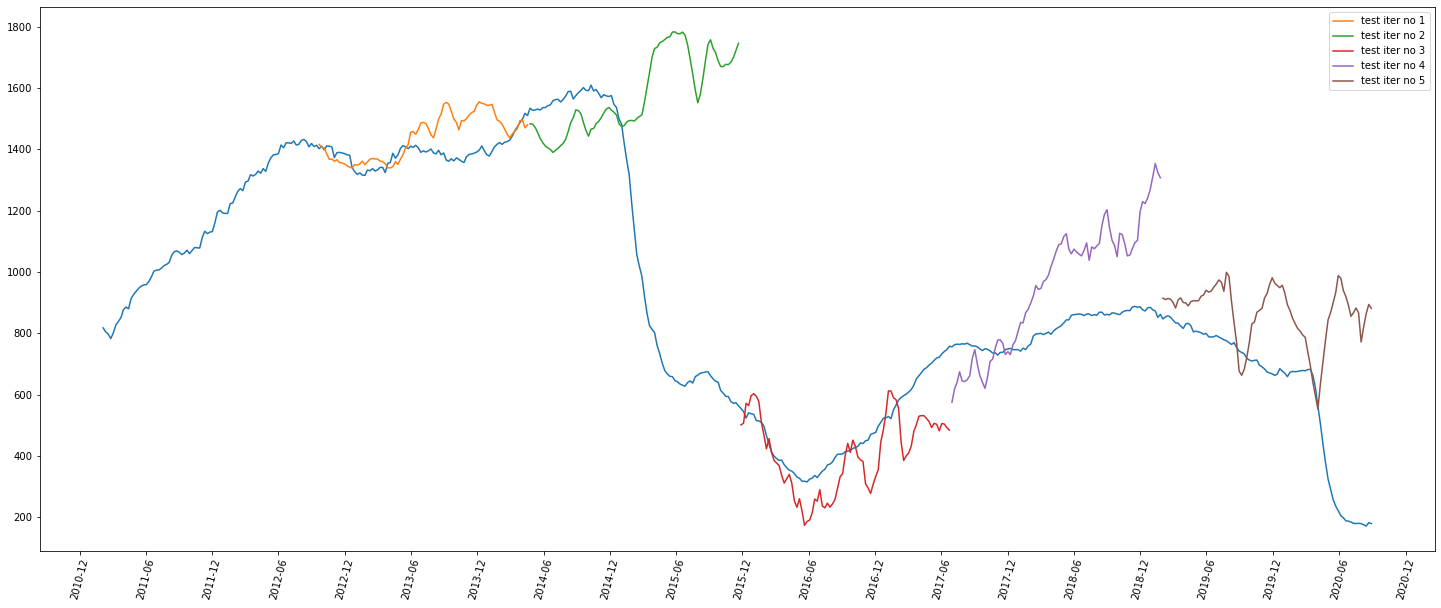

'rmse = 296.894831578791. r2 = -8.744830662560798'

In [9]:
# Let's try with rolling window for the time series to account for the data being non-stationary
cv = TimeSeriesSplit(n_splits=5,max_train_size=150)

plot_model(date,X,y,cv,pipe)

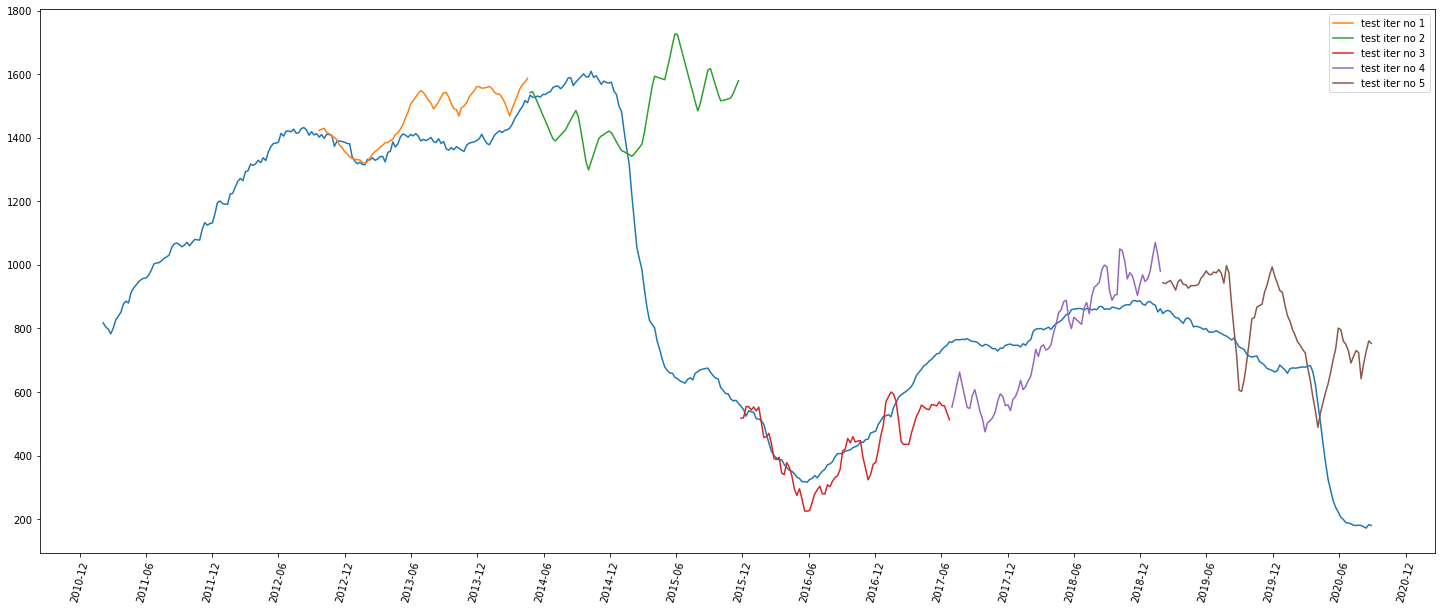

'rmse = 246.04564423659866. r2 = -7.8231109865504695'

In [10]:
# Parameter tuning for linear regression
feat_sel = SelectKBest(f_regression)
pipe = make_pipeline(scaler,feat_sel,model)
param_grid = {'selectkbest__k':np.arange(1,len(X.columns)+1)}

gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [11]:
selected = gs_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = gs_cv.best_estimator_.named_steps.linearregression.coef_
features = X.columns[selected]
features = pd.Series(coefs, index=features).sort_values(ascending=False)

print(gs_cv.best_params_)
print(features)

{'selectkbest__k': 10}
world_cons           1.275163e+15
opec_tot_prod        2.794757e+02
opec_surp_capac      2.718852e+02
usa_l48_prod         1.789822e+02
wti_spot_lag_14      1.786495e+02
non-opec_tot_prod    1.514881e+02
usa_stocks_all       2.374977e+01
usa_net_import      -4.420549e+01
oecd_cons           -6.967231e+14
non-oecd_cons       -1.007956e+15
dtype: float64


### Ridge Regression 
Baseline model will be a ridge regression with default alpha.

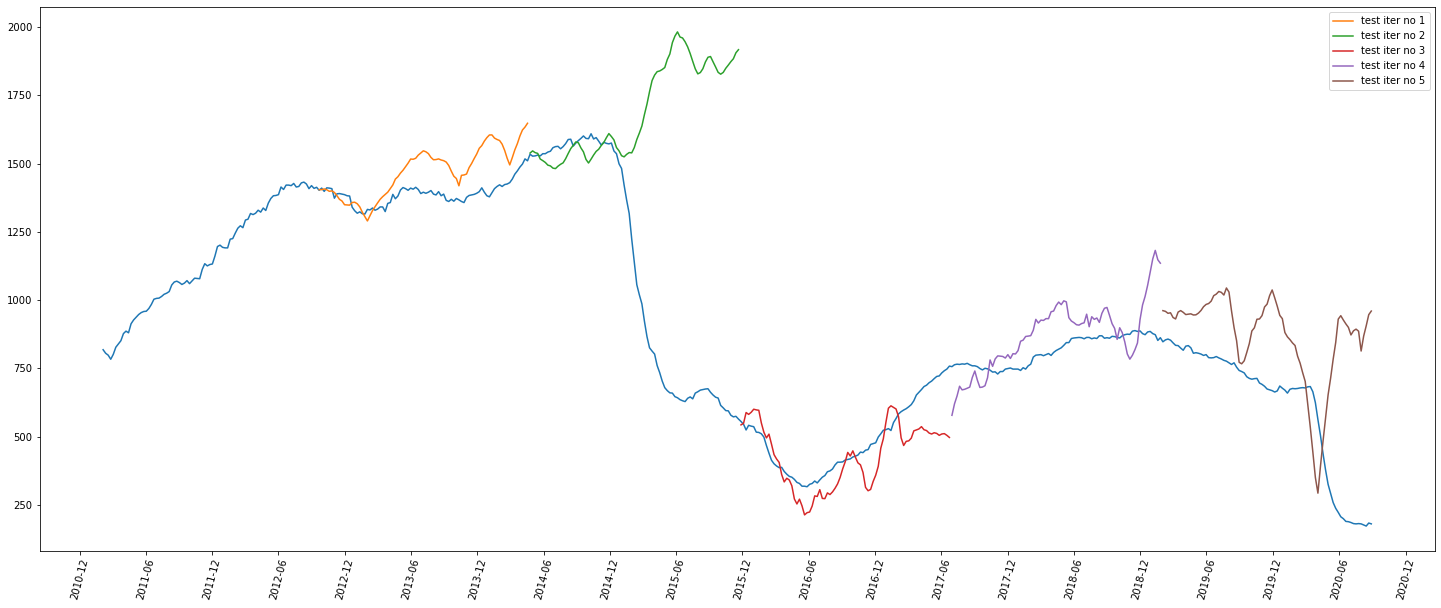

'rmse = 300.66702977929754. r2 = -5.35564035694278'

In [12]:
model = Ridge()
feat_sel = SelectKBest(f_regression, k=10)
pipe = make_pipeline(scaler,feat_sel,model)

plot_model(date,X,y,cv,pipe)

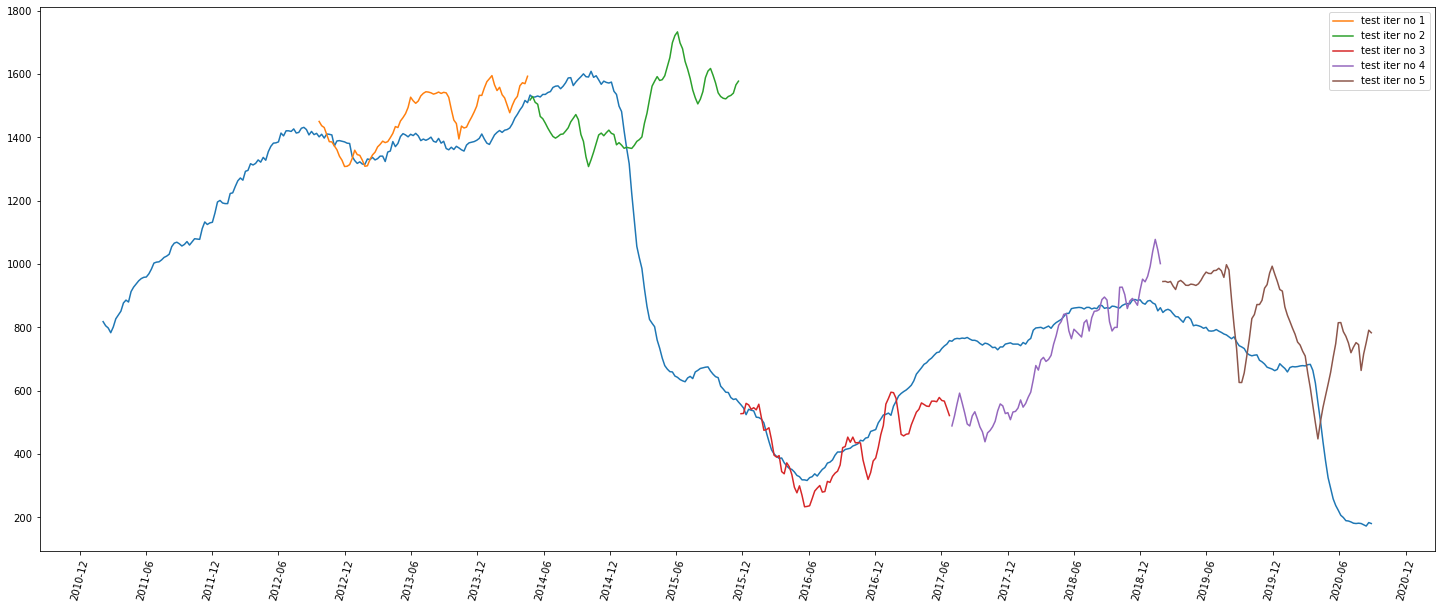

'rmse = 252.2038888129935. r2 = -8.26381231307689'

In [13]:
param_grid = {'ridge__alpha':np.arange(0.1,0.12,step=0.1),'selectkbest__k':np.arange(1,len(X.columns)+1)}
gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

In [14]:
print(gs_cv.best_estimator_.named_steps.ridge)

Ridge(alpha=0.1)


### Lasso Regression 
Baseline model will be a lasso regression with no alpha optimisation.

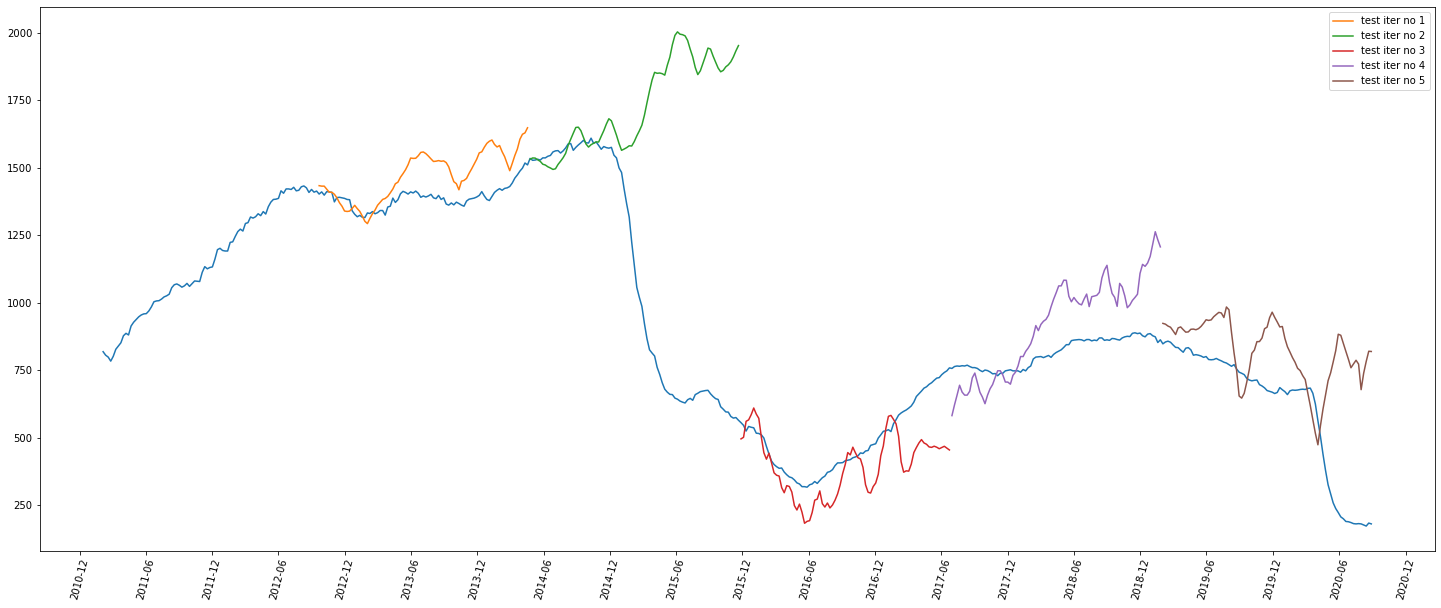

'rmse = 310.3162764397888. r2 = -6.287800794321666'

In [15]:
model = Lasso()
pipe = make_pipeline(scaler,feat_sel,model)
param_grid = {'selectkbest__k':np.arange(1,len(X.columns)+1)}

plot_model(date,X,y,cv,model)

In [ ]:
param_grid = {'lasso__alpha':np.arange(0.01,1,step=0.005),'selectkbest__k':np.arange(0,len(X.columns))}
gs_cv = GridSearchCV(pipe,param_grid=param_grid,cv=cv,n_jobs=-1)

plot_model(date,X,y,cv,gs_cv)

C:\Users\bryan\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18406.868597288623, tolerance: 335.29671058823527
  model = cd_fast.enet_coordinate_descent(


In [ ]:
print(gs_cv.best_estimator_.named_steps.lasso)
print(gs_cv.best_estimator_.named_steps.selectkbest)

### Random Forest Regression 
Baseline model will be a default RF regression